# Vertex Cover Experiment Notebook (with Graphs)

### Project Objective
This experiment is an in depth analysis of the vertex cover problem which is defined as "a set of vertices including at least one
endpoint of every edge." In this case, we are specifically looking for the minimum vertex cover, which finds the smallest set of vertices that still covers the whole graph. 

The C++ code for the vertex cover problem performed by three different algorithms (brute force, greedy, and 2-approximation) is provided below with comments from the writer (Mitchell Korody)

In [1]:
# Write source file
with open("project.cpp","w") as f: f.write("""#include <iostream>
#include <vector>
#include <set>
#include <algorithm>
#include <chrono>
#include <cmath>
#include <iomanip>
#include <climits>
#include <cfloat>
#include <cstdlib>
#include <ctime>
#include <string>

using namespace std;
using namespace chrono;

// Structure to represent an edge in the graph
struct Edge {
    int u, v;  // Two vertices that form the edge
    
    Edge(int u, int v) : u(u), v(v) {}
};

// Structure to represent a graph
class Graph {
public:
    int V;  // Number of vertices
    vector<Edge> edges;  // List of all edges
    vector<vector<int>> adjList;  // Adjacency list representation
    
    // Constructor: Initialize graph with V vertices
    Graph(int V) : V(V) {
        adjList.resize(V);
    }
    
    // Add an undirected edge between vertices u and v
    void addEdge(int u, int v) {
        edges.push_back(Edge(u, v));
        adjList[u].push_back(v);
        adjList[v].push_back(u);
    }
    
    // Print the graph structure
    void printGraph() {
        cout << "Graph with " << V << " vertices and " << edges.size() << " edges:\n";
        for (const auto& e : edges) {
            cout << "  (" << e.u << ", " << e.v << ")\n";
        }
    }
};

// Structure to store results from each algorithm
struct AlgorithmResult {
    string algorithmName;
    set<int> vertexCover;  // The vertices in the cover
    double timeMilliseconds;  // Execution time
    long long operationCount;  // Number of basic operations
    bool isOptimal;  // Whether this is guaranteed to be optimal
    
    void print() const {
        cout << "\n--- " << algorithmName << " ---\n";
        cout << "Vertex Cover Size: " << vertexCover.size() << "\n";
        cout << "Vertices: { ";
        for (int v : vertexCover) {
            cout << v << " ";
        }
        cout << "}\n";
        cout << "Execution Time: " << fixed << setprecision(3) << timeMilliseconds << " ms\n";
        cout << "Basic Operations: " << operationCount << "\n";
        cout << "Optimal: " << (isOptimal ? "Yes" : "No (Approximation)") << "\n";
    }
};

// ===========================
// ALGORITHM 1: BRUTE FORCE
// ===========================
// This algorithm checks ALL possible subsets of vertices to find the minimum vertex cover
// Time Complexity: O(2^V * V * E) where V = vertices, E = edges
// Space Complexity: O(V)
// Guarantees: Always finds the OPTIMAL (minimum size) solution

class BruteForceVC {
private:
    long long operations;
    
    // Helper function: Check if a given set of vertices covers all edges
    // A vertex cover is valid if every edge has at least one endpoint in the set
    bool isValidCover(const Graph& g, const set<int>& cover) {
        // Check each edge in the graph
        for (const auto& edge : g.edges) {
            operations += 2; // Two set lookups
            // If neither endpoint of the edge is in the cover, it's not valid
            if (cover.find(edge.u) == cover.end() && 
                cover.find(edge.v) == cover.end()) {
                return false;
            }
        }
        return true;  // All edges are covered
    }
    
    // Recursive function to generate all possible subsets of vertices
    // and find the minimum valid vertex cover
    void findMinCoverRecursive(const Graph& g, int vertex, set<int>& current, 
                            set<int>& minCover, int& minSize) {
        operations++; // Count recursive call
        
        // Pruning: If current set is already larger than best found, stop exploring
        if (current.size() >= minSize) {
            return;
        }
        
        // Base case: We've considered all vertices
        if (vertex == g.V) {
            // Check if this is a valid cover
            if (isValidCover(g, current)) {
                // Update minimum if this is smaller
                if (current.size() < minSize) {
                    minSize = current.size();
                    minCover = current;
                }
            }
            return;
        }
        
        // Recursive case 1: Include current vertex in the cover
        current.insert(vertex);
        findMinCoverRecursive(g, vertex + 1, current, minCover, minSize);
        current.erase(vertex);
        
        // Recursive case 2: Exclude current vertex from the cover
        findMinCoverRecursive(g, vertex + 1, current, minCover, minSize);
    }
    
public:
    AlgorithmResult solve(const Graph& g) {
        auto start = high_resolution_clock::now();
        operations = 0; // Reset operation counter
        
        set<int> current;  // Current subset being explored
        set<int> minCover;  // Best (minimum) cover found
        int minSize = g.V + 1;  // Initialize to impossible size
        
        // Start recursive search from vertex 0
        findMinCoverRecursive(g, 0, current, minCover, minSize);
        
        auto end = high_resolution_clock::now();
        auto duration = duration_cast<microseconds>(end - start).count() / 1000.0;
        
        return {"Brute Force (Exact)", minCover, duration, operations, true};
    }
};

// ===========================
// ALGORITHM 2: GREEDY APPROXIMATION
// ===========================
// This algorithm repeatedly selects the vertex with the highest degree (most uncovered edges)
// Time Complexity: O(V * E) where V = vertices, E = edges
// Space Complexity: O(V + E)
// Approximation Ratio: O(log V) - can be up to log(V) times larger than optimal

class GreedyVC {
public:
    AlgorithmResult solve(const Graph& g) {
        auto start = high_resolution_clock::now();
        long long operations = 0;
        
        set<int> cover;  // Our vertex cover solution
        set<Edge*> uncoveredEdges;  // Edges not yet covered
        
        // Initialize: All edges are uncovered
        for (const auto& edge : g.edges) {
            uncoveredEdges.insert(const_cast<Edge*>(&edge));
            operations++; // Count insertion
        }
        
        // Keep going until all edges are covered
        while (!uncoveredEdges.empty()) {
            // Count how many uncovered edges each vertex touches
            vector<int> degreeCount(g.V, 0);
            
            for (const Edge* e : uncoveredEdges) {
                degreeCount[e->u]++;
                degreeCount[e->v]++;
                operations += 2; // Two array accesses
            }
            
            // Find vertex with maximum degree among uncovered edges
            int maxDegreeVertex = -1;
            int maxDegree = -1;
            
            for (int v = 0; v < g.V; v++) {
                operations++; // Count comparison
                if (degreeCount[v] > maxDegree) {
                    maxDegree = degreeCount[v];
                    maxDegreeVertex = v;
                }
            }
            
            // Add this vertex to our cover
            cover.insert(maxDegreeVertex);
            operations++; // Count insertion
            
            // Remove all edges covered by this vertex
            auto it = uncoveredEdges.begin();
            while (it != uncoveredEdges.end()) {
                operations++; // Count edge check
                if ((*it)->u == maxDegreeVertex || (*it)->v == maxDegreeVertex) {
                    it = uncoveredEdges.erase(it);
                } else {
                    ++it;
                }
            }
        }
        
        auto end = high_resolution_clock::now();
        auto duration = duration_cast<microseconds>(end - start).count() / 1000.0;
        
        return {"Greedy Approximation", cover, duration, operations, false};
    }
};

// ===========================
// ALGORITHM 3: 2-APPROXIMATION (MATCHING-BASED)
// ===========================
// This algorithm picks arbitrary edges and adds BOTH endpoints to the cover
// Time Complexity: O(E) where E = edges
// Space Complexity: O(V)
// Approximation Ratio: 2 - guaranteed to be at most 2x the optimal solution

class TwoApproxVC {
public:
    AlgorithmResult solve(const Graph& g) {
        auto start = high_resolution_clock::now();
        long long operations = 0;
        
        set<int> cover;  // Our vertex cover solution
        vector<bool> edgeCovered(g.edges.size(), false);  // Track which edges are covered
        
        // Process each edge
        for (size_t i = 0; i < g.edges.size(); i++) {
            operations++; // Count edge check
            // Skip if this edge is already covered
            if (edgeCovered[i]) continue;
            
            const Edge& e = g.edges[i];
            
            // Add both endpoints of this edge to the cover
            cover.insert(e.u);
            cover.insert(e.v);
            operations += 2; // Two insertions
            
            // Mark all edges incident to these vertices as covered
            for (size_t j = 0; j < g.edges.size(); j++) {
                const Edge& other = g.edges[j];
                operations++; // Count comparison
                // An edge is covered if at least one endpoint is in the cover
                if (other.u == e.u || other.u == e.v || 
                    other.v == e.u || other.v == e.v) {
                    edgeCovered[j] = true;
                }
            }
        }
        
        auto end = high_resolution_clock::now();
        auto duration = duration_cast<microseconds>(end - start).count() / 1000.0;
        
        return {"2-Approximation (Matching)", cover, duration, operations, false};
    }
};

// ===========================
// UTILITY FUNCTIONS
// ===========================

// Create a random graph with specified vertices and edge probability
Graph createRandomGraph(int V, double edgeProbability) {
    Graph g(V);
    
    // Try to add each possible edge with given probability
    for (int i = 0; i < V; i++) {
        for (int j = i + 1; j < V; j++) {
            // Random value between 0 and 1
            double randVal = (double)rand() / RAND_MAX;
            if (randVal < edgeProbability) {
                g.addEdge(i, j);
            }
        }
    }
    
    return g;
}

// Create a complete graph (every vertex connected to every other vertex)
Graph createCompleteGraph(int V) {
    Graph g(V);
    for (int i = 0; i < V; i++) {
        for (int j = i + 1; j < V; j++) {
            g.addEdge(i, j);
        }
    }
    return g;
}

// Create a cycle graph (vertices connected in a ring)
Graph createCycleGraph(int V) {
    Graph g(V);
    for (int i = 0; i < V; i++) {
        g.addEdge(i, (i + 1) % V);
    }
    return g;
}

// Create a path graph (vertices connected in a line)
Graph createPathGraph(int V) {
    Graph g(V);
    for (int i = 0; i < V - 1; i++) {
        g.addEdge(i, i + 1);
    }
    return g;
}

// Verify that a vertex cover is valid (covers all edges)
bool verifyCover(const Graph& g, const set<int>& cover) {
    for (const auto& edge : g.edges) {
        if (cover.find(edge.u) == cover.end() && 
            cover.find(edge.v) == cover.end()) {
            return false;
        }
    }
    return true;
}

// Compare and print results from all algorithms
void compareResults(const vector<AlgorithmResult>& results, const Graph& g) {
    cout << "\n" << string(60, '=') << "\n";
    cout << "COMPARISON SUMMARY\n";
    cout << string(60, '=') << "\n";
    
    // Print each algorithm's results
    for (const auto& result : results) {
        result.print();
    }
    
    // Find optimal size (from brute force) or best size found
    int referenceSize = -1;
    bool hasOptimal = false;
    
    // First, look for optimal solution
    for (const auto& result : results) {
        if (result.isOptimal) {
            referenceSize = result.vertexCover.size();
            hasOptimal = true;
            break;
        }
    }
    
    // If no optimal solution, use the smallest solution found
    if (referenceSize == -1) {
        referenceSize = INT_MAX;
        for (const auto& result : results) {
            if (result.vertexCover.size() < referenceSize) {
                referenceSize = result.vertexCover.size();
            }
        }
    }
    
    // Calculate percent optimal
    cout << "\n--- Percent Optimal ---\n";
    for (const auto& result : results) {
        cout << result.algorithmName << ":\n";
        cout << "  Size: " << result.vertexCover.size();
        
        // Verify the cover is valid
        bool valid = verifyCover(g, result.vertexCover);
        cout << "\n  Valid: " << (valid ? "Yes" : "NO - ERROR!");
        
        // Calculate percent optimal (or percent of best found)
        if (referenceSize > 0) {
            double percentOptimal = ((double)referenceSize / result.vertexCover.size()) * 100.0;
            if (hasOptimal) {
                cout << "\n  Percent Optimal: " << fixed << setprecision(1) << percentOptimal << "%";
            } else {
                cout << "\n  Percent of Best: " << fixed << setprecision(1) << percentOptimal << "%";
            }
        }
        cout << "\n";
    }
    
    // Compare execution times and operation counts
    cout << "\n--- Performance Comparison ---\n";
    double minTime = DBL_MAX;
    for (const auto& result : results) {
        if (result.timeMilliseconds < minTime) {
            minTime = result.timeMilliseconds;
        }
    }
    
    for (const auto& result : results) {
        double speedup = result.timeMilliseconds / minTime;
        cout << result.algorithmName << ": " 
            << fixed << setprecision(3) << result.timeMilliseconds << " ms, "
            << result.operationCount << " ops ";
        if (speedup > 1.0) {
            cout << "(" << fixed << setprecision(2) << speedup << "x slower)";
        } else {
            cout << "(fastest)";
        }
        cout << "\n";
    }
}

// ===========================
// MAIN FUNCTION - INTERACTIVE EXPERIMENTS
// ===========================

int main() {
    srand(time(0));  // Seed random number generator
    
    // Create algorithm instances
    BruteForceVC bruteForce;
    GreedyVC greedy;
    TwoApproxVC twoApprox;
    
    cout << "VERTEX COVER ALGORITHM COMPARISON\n";
    cout << "Interactive Experiment Tool\n\n";
    
    char continueChoice = 'y';
    
    while (continueChoice == 'y' || continueChoice == 'Y') {
        // Graph type selection
        cout << "\nChoose graph type:\n";
        cout << "1. Random Graph\n";
        cout << "2. Complete Graph\n";
        cout << "3. Cycle Graph\n";
        cout << "4. Path Graph\n";
        cout << "Enter choice (1-4): ";
        
        int graphType;
        cin >> graphType;
        
        // Get number of vertices
        int vertices;
        cout << "Enter number of vertices: ";
        cin >> vertices;
        
        // Input validation
        if (vertices < 1) {
            cout << "Invalid input. Using 3 vertices.\n";
            vertices = 3;
        } else if (vertices > 25) {
            cout << "Warning: Recommended range is 1-25 vertices for performance.\n";
        }
        
        // Create graph based on user choice
        Graph g(1);
        string graphDescription;
        
        switch (graphType) {
            case 1: {
                double probability;
                cout << "Enter edge probability (0.0-1.0): ";
                cin >> probability;
                if (probability < 0.0 || probability > 1.0) {
                    cout << "Invalid probability. Using 0.3\n";
                    probability = 0.3;
                }
                g = createRandomGraph(vertices, probability);
                graphDescription = "Random Graph (" + to_string(vertices) + " vertices, " + 
                                 to_string((int)(probability * 100)) + "% edge probability)";
                break;
            }
            case 2:
                g = createCompleteGraph(vertices);
                graphDescription = "Complete Graph (" + to_string(vertices) + " vertices)";
                break;
            case 3:
                if (vertices < 3) {
                    cout << "Cycle graph needs at least 3 vertices. Using 3.\n";
                    vertices = 3;
                }
                g = createCycleGraph(vertices);
                graphDescription = "Cycle Graph (" + to_string(vertices) + " vertices)";
                break;
            case 4:
                if (vertices < 2) {
                    cout << "Path graph needs at least 2 vertices. Using 2.\n";
                    vertices = 2;
                }
                g = createPathGraph(vertices);
                graphDescription = "Path Graph (" + to_string(vertices) + " vertices)";
                break;
            default:
                cout << "Invalid choice. Creating random graph.\n";
                g = createRandomGraph(vertices, 0.3);
                graphDescription = "Random Graph (" + to_string(vertices) + " vertices, 30% edge probability)";
        }
        
        // Algorithm selection
        cout << "\nChoose algorithms to run:\n";
        cout << "1. All algorithms (recommended for <=15 vertices)\n";
        cout << "2. Approximation algorithms only\n";
        cout << "3. 2-Approximation only (fastest)\n";
        cout << "Enter choice (1-3): ";
        
        int algoChoice;
        cin >> algoChoice;
        
        // Input validation for algorithm choice
        if (algoChoice < 1 || algoChoice > 3) {
            cout << "Invalid choice. Using all algorithms.\n";
            algoChoice = 1;
        }
        
        // Display test header
        cout << "\n" << string(60, '=') << "\n";
        cout << "TEST: " << graphDescription << "\n";
        cout << string(60, '=') << "\n";
        
        g.printGraph();
        
        // Run selected algorithms
        vector<AlgorithmResult> results;
        
        if (algoChoice == 1) {
            // All algorithms with warning for large graphs
            if (vertices > 15) {
                cout << "\nWarning: Brute force may be slow for >15 vertices. Continue? (y/n): ";
                char confirm;
                cin >> confirm;
                if (confirm == 'y' || confirm == 'Y') {
                    results.push_back(bruteForce.solve(g));
                }
            } else {
                results.push_back(bruteForce.solve(g));
            }
            results.push_back(greedy.solve(g));
            results.push_back(twoApprox.solve(g));
        } else if (algoChoice == 2) {
            // Approximation algorithms only
            results.push_back(greedy.solve(g));
            results.push_back(twoApprox.solve(g));
        } else {
            // 2-Approximation only (fastest option)
            results.push_back(twoApprox.solve(g));
        }
        
        compareResults(results, g);
        
        // Ask to continue
        cout << "\nRun another experiment? (y/n): ";
        cin >> continueChoice;
    }
    
    cout << "\n" << string(60, '=') << "\n";
    cout << "EXPERIMENTS COMPLETE\n";
    cout << string(60, '=') << "\n";
    
    return 0;
}""")
print("C++ code loaded.")

C++ code loaded.


Now we will compile the code and run the executable file

In [2]:
!g++ project.cpp -O2 -o project.exe

project.cpp:45:75: warning: missing terminating " character
   45 |         cout << "Graph with " << V << " vertices and " << edges.size() << " edges:
      |                                                                           ^
project.cpp:45:75: error: missing terminating " character
   45 |         cout << "Graph with " << V << " vertices and " << edges.size() << " edges:
      |                                                                           ^~~~~~~~
project.cpp:46:1: warning: missing terminating " character
   46 | ";
      | ^
project.cpp:46:1: error: missing terminating " character
   46 | ";
      | ^~
project.cpp:48:52: warning: missing terminating " character
   48 |             cout << "  (" << e.u << ", " << e.v << ")
      |                                                    ^
project.cpp:48:52: error: missing terminating " character
   48 |             cout << "  (" << e.u << ", " << e.v << ")
      |                                                    ^~
p

In [3]:
!./project.exe

'.' is not recognized as an internal or external command,
operable program or batch file.


### Data analysis

In order for us to visualize the performance of the algorithms, we can run the algorithms repeatedly with a certain range of inputs

In [4]:
import subprocess
def run_input(s):
    return subprocess.run(["project.exe"],input=s.encode(),stdout=subprocess.PIPE).stdout.decode()


In [5]:
import subprocess

def run_input(input_str):
    """Run the C++ vertex cover program with the given input string."""
    exe_name = "./project"
    proc = subprocess.Popen(
        [exe_name],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    out, err = proc.communicate(input_str)
    if err:
        print("Error:", err)
    return out


The cell below downloads the matplot librarty that allows us to view plots

In [7]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 3.2 MB/s eta 0:00:03
   ----- ---------------------------------- 1.0/8.1 MB 3.1 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/8.1 MB 3.3 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 3.3 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 2.4 MB/s eta 0:00:03
   --------------- ------------------------ 3.1/8.1 MB 2.6 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 2.7 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 2.7 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 2.7 MB/s eta 0:00:02
   --------------------------- ------------ 5.5/8.1 MB 2.7 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 2.7 MB/s eta 0:00:01
   --------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\antho\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


The code block below hows how we plot the outputs of the algorithms for each input
* select a range of inputs to run every algorithm (16 seemed to be the most time efficient)
* create lists for the times and covers for each algorithm
* find the covers and times of each algorithm in the terminal output and append them to their respective lists

In [8]:
import matplotlib.pyplot as plt

vertex_counts = range(5,16)

# Separate lists for each algorithm
times = {
    "Brute Force": [],
    "Greedy": [],
    "2-Approx": []
}
covers = {
    "Brute Force": [],
    "Greedy": [],
    "2-Approx": []
}

for V in vertex_counts:
    # Construct input string for the experiment
    input_str = f"1\n{V}\n0.3\n1\nn\n"  # "1" = All algorithms
    out = run_input(input_str)
    
    # Temporary storage for this vertex count
    t_temp = {"Brute Force": None, "Greedy": None, "2-Approx": None}
    c_temp = {"Brute Force": None, "Greedy": None, "2-Approx": None}
    
    # Parse output line by line
    for line in out.splitlines():
        line = line.strip()
        if line.startswith("--- Brute Force"):
            alg = "Brute Force"
        elif line.startswith("--- Greedy"):
            alg = "Greedy"
        elif line.startswith("--- 2-Approx"):
            alg = "2-Approx"
        elif "Vertex Cover Size:" in line:
            c_temp[alg] = int(line.split(":")[1].strip())
        elif "Execution Time:" in line:
            # Remove 'ms' and convert to float
            t_temp[alg] = float(line.split(":")[1].strip().split()[0])
    
    # Append parsed values to main lists
    for alg in times.keys():
        times[alg].append(t_temp[alg])
        covers[alg].append(c_temp[alg])


Plot execution time vs. number of vertices

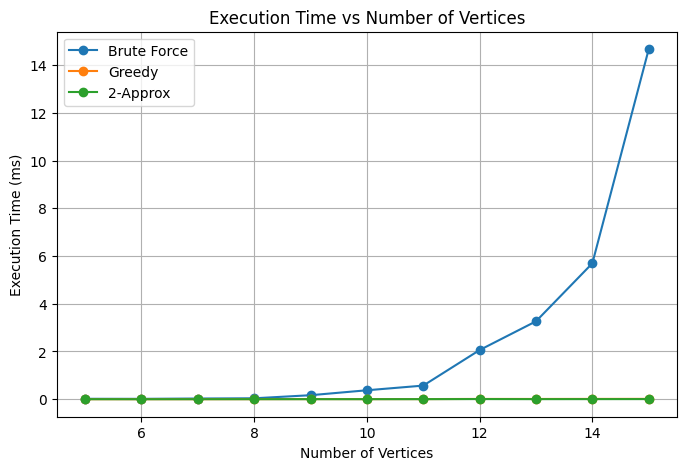

In [9]:
# --- Plot Execution Times ---
plt.figure(figsize=(8,5))
for alg in times:
    plt.plot(list(vertex_counts), times[alg], marker='o', label=alg)
plt.title("Execution Time vs Number of Vertices")
plt.xlabel("Number of Vertices")
plt.ylabel("Execution Time (ms)")
plt.legend()
plt.grid(True)
plt.show()


Plot vertex cover size vs. number of vertices

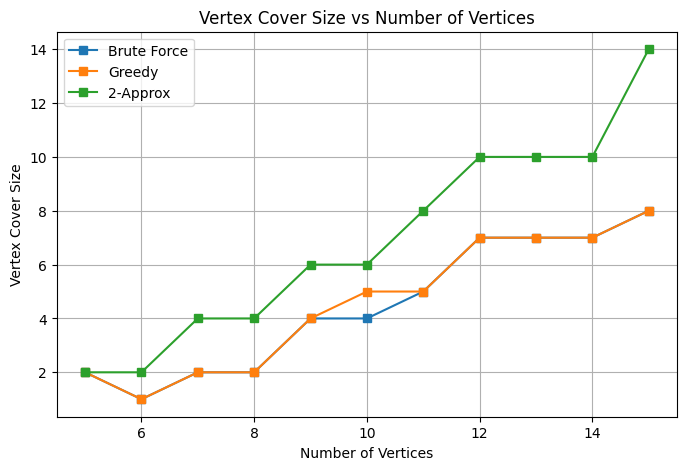

In [10]:

# --- Plot Cover Sizes ---
plt.figure(figsize=(8,5))
for alg in covers:
    plt.plot(list(vertex_counts), covers[alg], marker='s', label=alg)
plt.title("Vertex Cover Size vs Number of Vertices")
plt.xlabel("Number of Vertices")
plt.ylabel("Vertex Cover Size")
plt.legend()
plt.grid(True)
plt.show()